In [1]:
# To have reproducible results and compare them
nr_seed = 2024

import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.random.set_seed(nr_seed)

In [2]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.resnet50 import ResNet50
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np

from tqdm import tqdm_notebook
from concurrent.futures import ThreadPoolExecutor, as_completed

# Dataset 1 : EyePACS 

In [3]:
import sklearn.model_selection

#import the first dataset ()
df1 = pd.read_csv('/kaggle/input/diabetic-retinopathy-resized/trainLabels.csv')
# img_path = '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/'
img_path = '/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/'
df1['img_path'] = img_path + df1.image + '.jpeg'

df1 = df1.drop(columns=['image'])

# Rename a single column
df1.rename(columns={"level": "grade"}, inplace=True)

# Reorder the columns to make the second column the first
cols = df1.columns.tolist()  # Get a list of all column names
cols = [cols[1]] + [cols[0]] + cols[2:]  # Move the second column to the first position

# Apply the new order to the DataFrame
df1 = df1[cols]
df1

img_path  grade
0      /kaggle/input/diabetic-retinopathy-resized/res...      0
1      /kaggle/input/diabetic-retinopathy-resized/res...      0
2      /kaggle/input/diabetic-retinopathy-resized/res...      0
3      /kaggle/input/diabetic-retinopathy-resized/res...      0
4      /kaggle/input/diabetic-retinopathy-resized/res...      1
...                                                  ...    ...
35121  /kaggle/input/diabetic-retinopathy-resized/res...      0
35122  /kaggle/input/diabetic-retinopathy-resized/res...      0
35123  /kaggle/input/diabetic-retinopathy-resized/res...      0
35124  /kaggle/input/diabetic-retinopathy-resized/res...      0
35125  /kaggle/input/diabetic-retinopathy-resized/res...      1

[35126 rows x 2 columns]

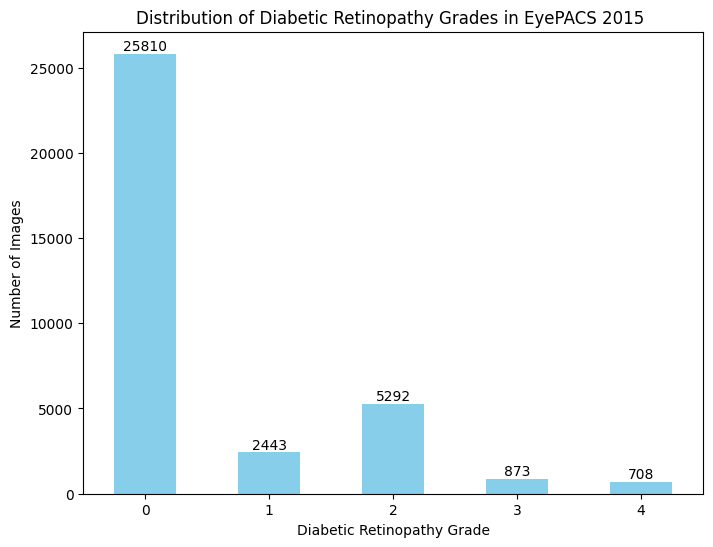

   Diagnosis Grade  Frequency
0                0      25810
1                1       2443
2                2       5292
3                3        873
4                4        708


In [4]:
df1_grade_distribution = df1['grade'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = df1_grade_distribution.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in EyePACS 2015 ')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(df1_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a table to show grade distribution in EyePACS 2015
df1_grade_distribution_table = pd.DataFrame({'Diagnosis Grade': df1_grade_distribution.index, 'Frequency': df1_grade_distribution.values})
print(df1_grade_distribution_table)

# Dataset 2 : APTOS 2019

In [5]:
df2 = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
df2["img_path"] = df2["id_code"].map(lambda x:os.path.join("../input/aptos2019-blindness-detection/train_images",x+".png"))
# Rename multiple columns
df2.rename(columns={"id_code": "image", "diagnosis": "grade"}, inplace=True)

df2 = df2.drop(columns=['image'])

# Reorder the columns to make the second column the first
cols = df2.columns.tolist()  # Get a list of all column names
cols = [cols[1]] + [cols[0]] + cols[2:]  # Move the second column to the first position

# Apply the new order to the DataFrame
df2 = df2[cols]
df2

# Display the DataFrame with renamed columns
df2

img_path  grade
0     ../input/aptos2019-blindness-detection/train_i...      2
1     ../input/aptos2019-blindness-detection/train_i...      4
2     ../input/aptos2019-blindness-detection/train_i...      1
3     ../input/aptos2019-blindness-detection/train_i...      0
4     ../input/aptos2019-blindness-detection/train_i...      0
...                                                 ...    ...
3657  ../input/aptos2019-blindness-detection/train_i...      2
3658  ../input/aptos2019-blindness-detection/train_i...      0
3659  ../input/aptos2019-blindness-detection/train_i...      2
3660  ../input/aptos2019-blindness-detection/train_i...      0
3661  ../input/aptos2019-blindness-detection/train_i...      2

[3662 rows x 2 columns]

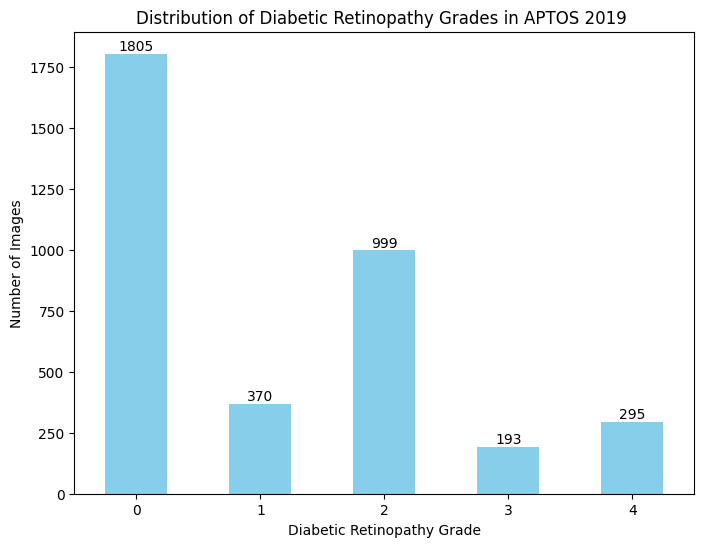

   Diagnosis Grade  Frequency
0                0       1805
1                1        370
2                2        999
3                3        193
4                4        295


In [6]:
df2_grade_distribution = df2['grade'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = df2_grade_distribution.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in APTOS 2019 ')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(df2_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a table to show grade distribution in EyePACS 2015
df2_grade_distribution_table = pd.DataFrame({'Diagnosis Grade': df2_grade_distribution.index, 'Frequency': df2_grade_distribution.values})
print(df2_grade_distribution_table)

# Dataset 3: Messidor-2

In [7]:
df3 = pd.read_csv('../input/messidor2preprocess/messidor_data.csv')
# Drop the columns adjudicated_dme and adjudicated_gradable
df3.drop(['adjudicated_dme', 'adjudicated_gradable'], axis=1, inplace=True)
df3["img_path"] = df3["id_code"].map(lambda x:os.path.join("../input/messidor2preprocess/messidor-2/messidor-2/preprocess",x))

df3 = df3.drop(columns=['id_code'])
df3.rename(columns={"diagnosis": "grade"}, inplace=True)

# Reorder the columns to make the second column the first
cols = df3.columns.tolist()  # Get a list of all column names
cols = [cols[1]] + [cols[0]] + cols[2:]  # Move the second column to the first position

# Apply the new order to the DataFrame
df3 = df3[cols]

# Display the DataFrame with renamed columns
df3

img_path  grade
0     ../input/messidor2preprocess/messidor-2/messid...      0
1     ../input/messidor2preprocess/messidor-2/messid...      1
2     ../input/messidor2preprocess/messidor-2/messid...      1
3     ../input/messidor2preprocess/messidor-2/messid...      2
4     ../input/messidor2preprocess/messidor-2/messid...      0
...                                                 ...    ...
1739  ../input/messidor2preprocess/messidor-2/messid...      0
1740  ../input/messidor2preprocess/messidor-2/messid...      1
1741  ../input/messidor2preprocess/messidor-2/messid...      2
1742  ../input/messidor2preprocess/messidor-2/messid...      0
1743  ../input/messidor2preprocess/messidor-2/messid...      0

[1744 rows x 2 columns]

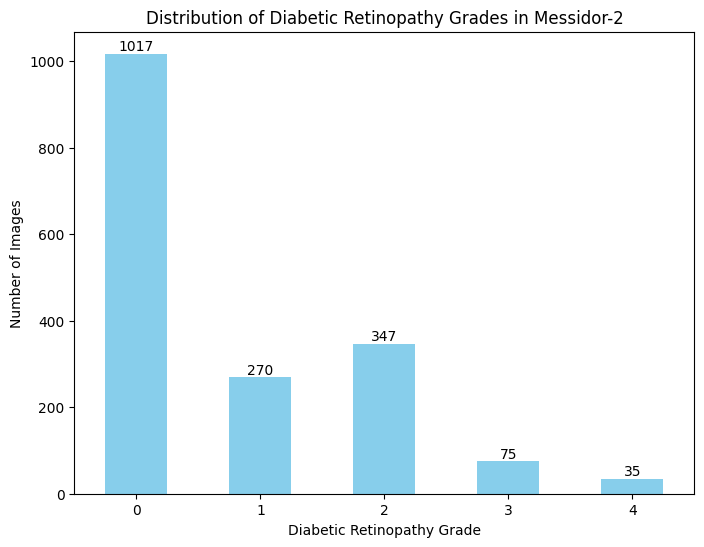

   Diagnosis Grade  Frequency
0                0       1017
1                1        270
2                2        347
3                3         75
4                4         35


In [8]:
df3_grade_distribution = df3['grade'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = df3_grade_distribution.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in Messidor-2')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(df3_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a table to show grade distribution in EyePACS 2015
df3_grade_distribution_table = pd.DataFrame({'Diagnosis Grade': df3_grade_distribution.index, 'Frequency': df3_grade_distribution.values})
print(df3_grade_distribution_table)

# Combined 3 dataset

In [9]:
# Combine the DataFrames (assuming row-wise concatenation as before)
combined_df = pd.concat([df1, df2, df3], axis=0)

combined_df

img_path  grade
0     /kaggle/input/diabetic-retinopathy-resized/res...      0
1     /kaggle/input/diabetic-retinopathy-resized/res...      0
2     /kaggle/input/diabetic-retinopathy-resized/res...      0
3     /kaggle/input/diabetic-retinopathy-resized/res...      0
4     /kaggle/input/diabetic-retinopathy-resized/res...      1
...                                                 ...    ...
1739  ../input/messidor2preprocess/messidor-2/messid...      0
1740  ../input/messidor2preprocess/messidor-2/messid...      1
1741  ../input/messidor2preprocess/messidor-2/messid...      2
1742  ../input/messidor2preprocess/messidor-2/messid...      0
1743  ../input/messidor2preprocess/messidor-2/messid...      0

[40532 rows x 2 columns]

         df1   df2   df3  combined
grade                             
0      25810  1805  1017     28632
1       2443   370   270      3083
2       5292   999   347      6638
3        873   193    75      1141
4        708   295    35      1038


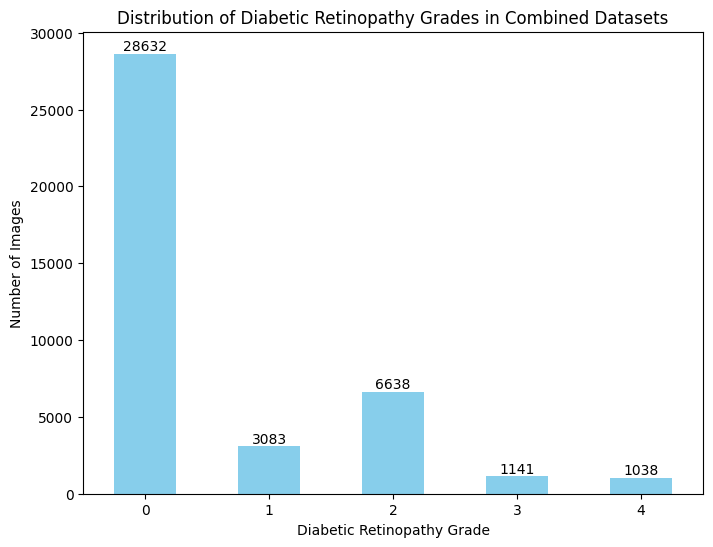

   Class  Frequency
0      0      28632
1      1       3083
2      2       6638
3      3       1141
4      4       1038


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

combined_grade_distribution = combined_df['grade'].value_counts().sort_index()

# Create a DataFrame with class distribution for all datasets
distribution_table = pd.DataFrame({
    'df1': df1_grade_distribution,
    'df2': df2_grade_distribution,
    'df3': df3_grade_distribution,
    'combined': combined_grade_distribution
})

# Fill missing values with 0 if a class does not appear in a dataset
distribution_table = distribution_table.fillna(0).astype(int)

# Display the class distribution table
print(distribution_table)

# Plot the bar chart for the combined dataset
plt.figure(figsize=(8, 6))
ax = combined_grade_distribution.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in Combined Datasets')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(combined_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a class distribution table for the combined dataset
combined_grade_distribution_table = pd.DataFrame({
    'Class': combined_grade_distribution.index,
    'Frequency': combined_grade_distribution.values
})

print(combined_grade_distribution_table)

## Print sample image 

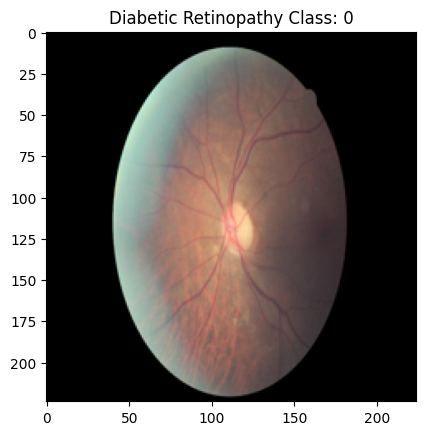

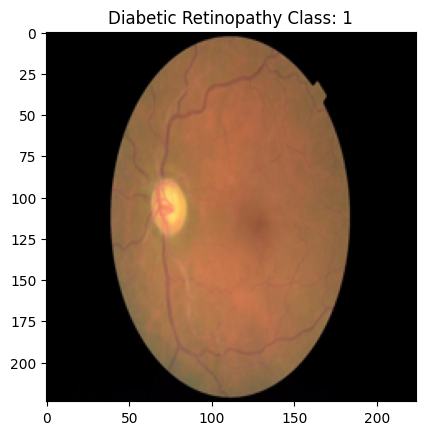

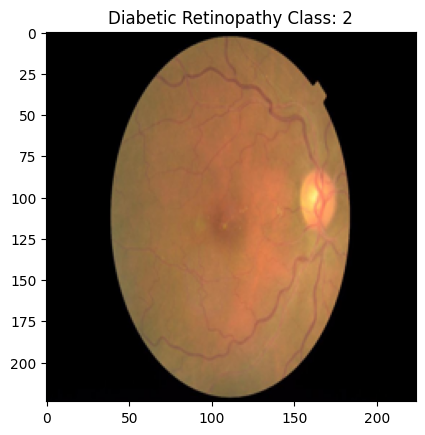

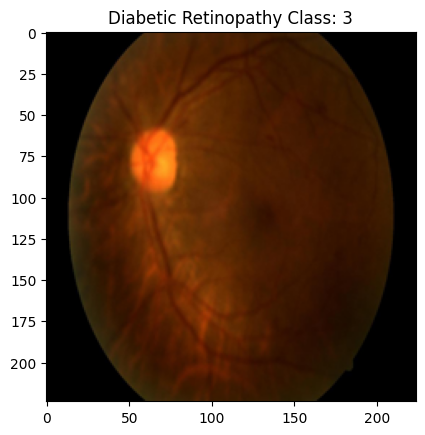

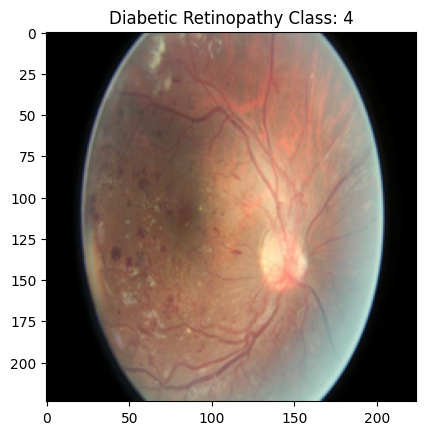

In [11]:
def show_example_of_each_grade(img_paths, labels, img_size):
    """
    Show one example image for each grade (0 to 4).

    Parameters:
    - img_paths: List of image file paths.
    - labels: List of corresponding labels (grades).
    - img_size: Size to which images should be resized.
    """
    examples = {grade: None for grade in range(5)}  # Dictionary to hold examples for each grade

    # Iterate through the images to find one example for each grade
    for img_path, label in zip(img_paths, labels):
        if examples[label] is None:  # If we haven't collected an example for this label
            # Load and resize the image
            img = Image.open(img_path).resize((img_size, img_size))
            examples[label] = img  # Store the image

        # Stop if we have collected examples for all grades (0 to 4)
        if all(examples.values()):
            break
    
    # Visualize one example for each grade
    for grade, example_img in sorted(examples.items()):
        if example_img is not None:  # Only show if an example exists
            plt.imshow(example_img)
            plt.title(f'Diabetic Retinopathy Grade: {grade}')
            plt.axis('off')  # Turn off axis
            plt.show()

# Example usage:
# Assuming img_paths and labels are already defined and combined_df is available
img_paths = combined_df['img_path'].values
labels = combined_df['grade'].values  # Assuming 'grade' column contains the labels
img_size = 224  # Example image size

# Show example of each grade
show_example_of_each_grade(img_paths, labels, img_size)

# Data Preprocessing

In [12]:
# Image size
im_size = 224
# Batch size
BATCH_SIZE = 32

In [73]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df['img_path'].iloc[i]
        image_id = df['grade'].iloc[i]
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

In [20]:
# Optimized function using ThreadPoolExecutor for parallelism
def load_images_in_parallel(image_paths, im_size, max_workers=8):
    N = len(image_paths)
    x_combined = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
    
    # Use ThreadPoolExecutor for parallel image processing
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(preprocess_image, image_path, im_size): idx for idx, image_path in enumerate(image_paths)}
        
        # Iterate over completed futures
        for future in tqdm_notebook(as_completed(futures), total=len(futures)):
            idx = futures[future]
            try:
                x_combined[idx, :, :, :] = future.result()  # Assign the result to x_combined
            except Exception as e:
                print(f"Error processing image {image_paths[idx]}: {e}")

    return x_combined

In [21]:
image_paths = combined_df['img_path'].tolist()  # Convert DataFrame column to a list of image paths
preprocessed_combined = load_images_in_parallel(image_paths, im_size)

  0%|          | 0/40532 [00:00<?, ?it/s]

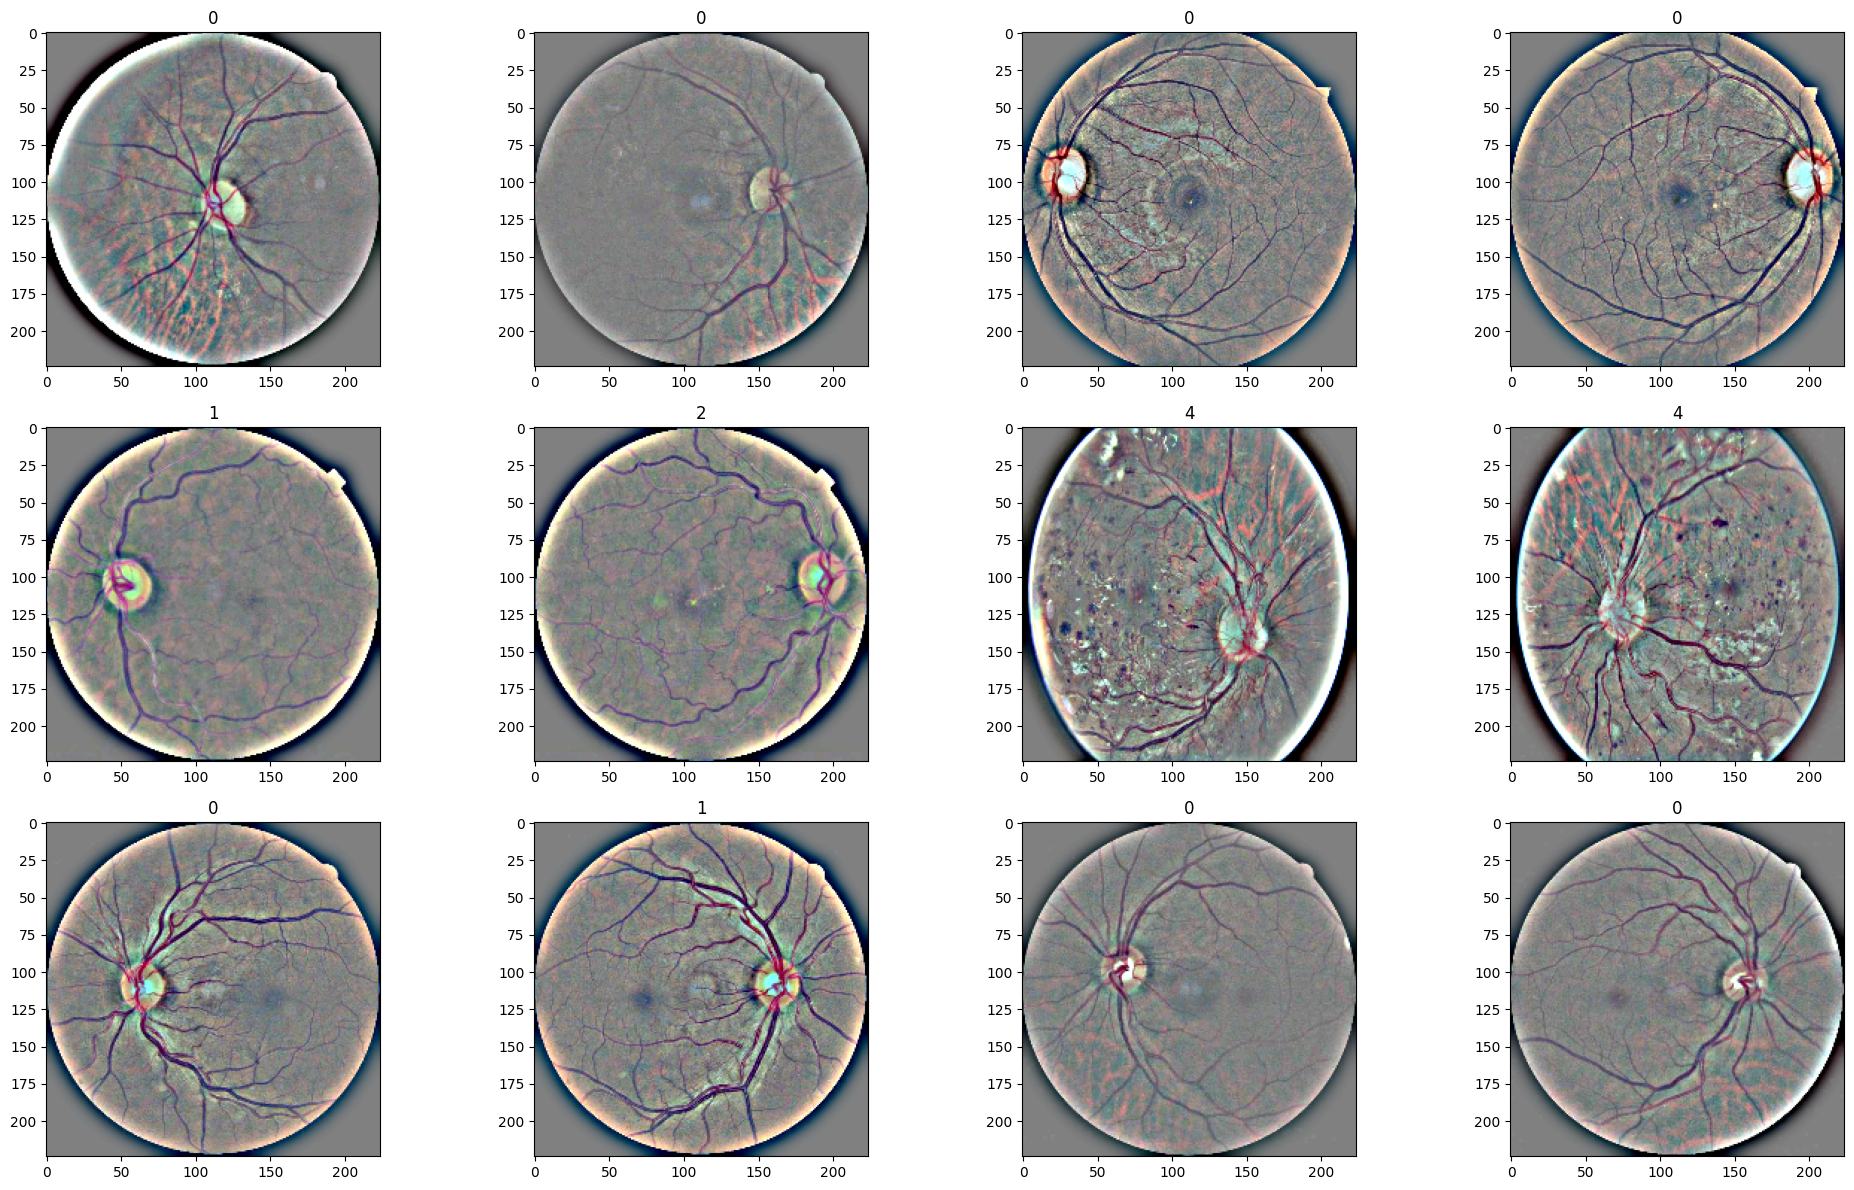

In [78]:
display_samples(combined_df)

**This serve as confirmation that the images are under the correct preprocessing step**

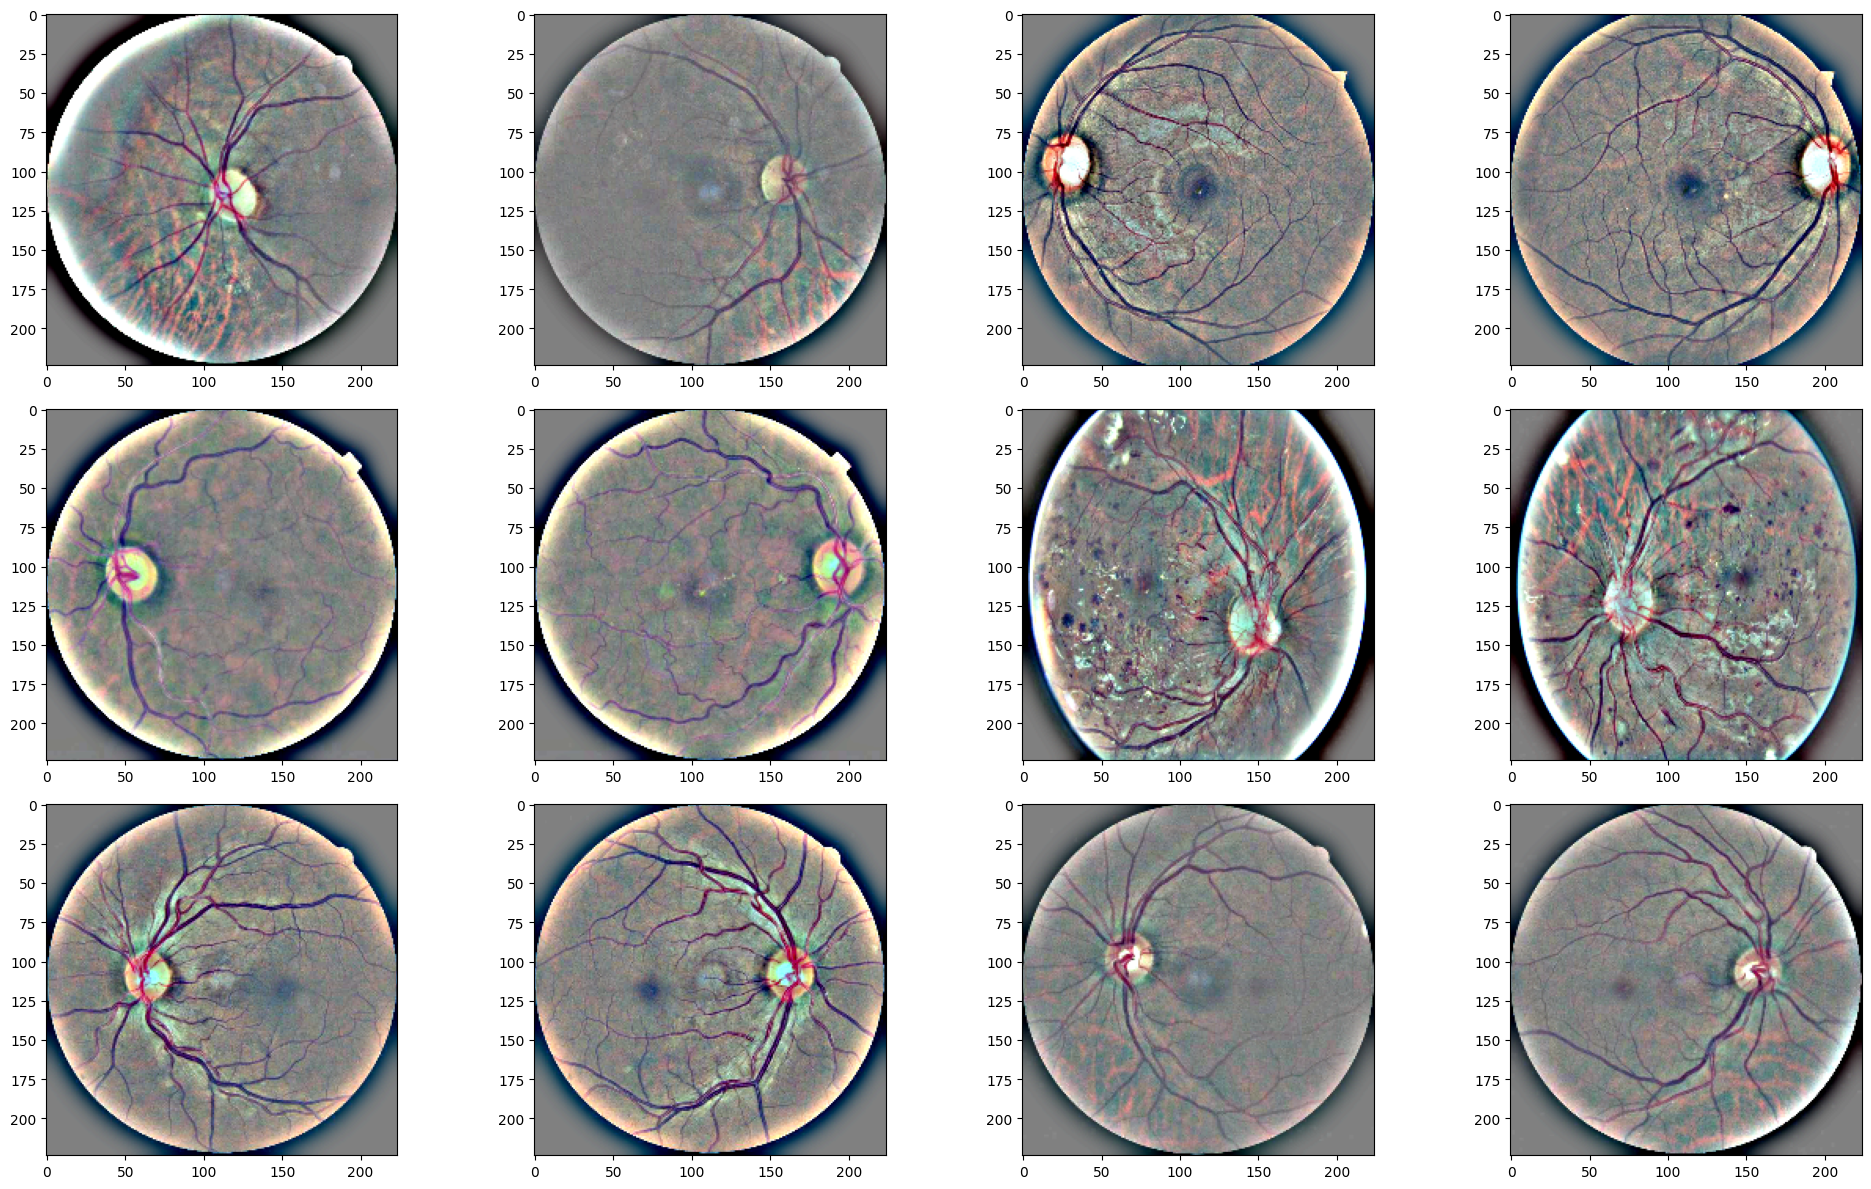

In [89]:
# Set the number of images to display
num_images_to_display = min(12, len(preprocessed_combined))  # Ensure we don't exceed the number of available images

# Define number of rows and columns for the grid
columns = 4  # You can adjust this number based on your preference
rows = 3

# Create a figure with subplots in a grid layout
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))  # Adjust figure size as needed

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(num_images_to_display):
    axes[i].imshow(preprocessed_combined[i])  # Display the image

plt.tight_layout()  # Adjust layout to prevent overlap